# Spaceship. Part 4. New start.

## Task description

To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.

## Starting over

We'll start over, tweaking some steps of the process and testing every step using the best classifier we've found in Part 3.

We'll repeat all the commentary, so it will be conveinient for readers to start from Part 4, without reading previous parts.

## Test function

But first, let's create a function that allows us easily test every new step by providing cross-validation average ROC AUC and accuracy scores, as well as preparing data for new submissions:

In [885]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

# Random seed for reproducibility
SEED = 123

# Prepare our best model for training
from sklearn.ensemble import RandomForestClassifier
model_for_tests = RandomForestClassifier(random_state=SEED, \
                               n_estimators= 516, \
                               criterion= 'log_loss', \
                               max_depth= 17, \
                               max_features=0.7, \
                               max_leaf_nodes=123,\
                               min_impurity_decrease= 0.00020380822483963789, \
                               min_samples_leaf= 2, \
                               max_samples= 0.9999360987512214, \
                               n_jobs=-1
                               )



def get_cv_scores(train, test, model, scores_df, comment = "", verbose=False, prepare_submission=False):
    
    '''
    This function takes train and test sets, as well as a model for cross validation and a DataFrame with previous scores.
    It also takes an optional comment string to comment changes.
    
    Setting verbose to True makes function printing out updated scores.

    
    It returns:
        
        -) Updated DataFrame with new:
            1) Average training ROC AUC score.
            2) Average cross-validation ROC AUC score.
            3) Average training accuracy score. 
            4) Average cross-validation accuracy score.
        
        -) A dataset for a new submission, if prepare_submission is True
    '''
    
    # Create a StratifiedKFold object (6 splits with equal proportion of positive target values)
    skf = StratifiedKFold(n_splits=6, shuffle=True, random_state=SEED)
    
    # Empty lists for collecting scores
    train_roc_auc_scores = []
    cv_roc_auc_scores = []
    train_accuracy_scores = []
    cv_accuracy_scores = []
    
    # Iterate through folds
    for train_index, cv_index in skf.split(train.drop('Transported', axis=1), train['Transported']):
        # Obtain training and testing folds
        cv_train, cv_test = train.iloc[train_index], train.iloc[cv_index]
        
        # Fit the model
        model.fit(cv_train.drop('Transported', axis=1), cv_train['Transported']) 
        
        # Calculate scores and append to the scores lists
        train_pred_proba = model.predict_proba(cv_train.drop('Transported', axis=1))[:, 1]
        train_roc_auc_scores.append(roc_auc_score(cv_train['Transported'], train_pred_proba))
        cv_pred_proba = model.predict_proba(cv_test.drop('Transported', axis=1))[:, 1]
        cv_roc_auc_scores.append(roc_auc_score(cv_test['Transported'], cv_pred_proba))
        train_accuracy_scores.append(model.score(cv_train.drop('Transported', axis=1), cv_train['Transported']))
        cv_accuracy_scores.append(model.score(cv_test.drop('Transported', axis=1), cv_test['Transported']))
        

    # Update the scores DataFrame with average scores:
    
    scores_df.loc[len(scores_df)] = [comment, np.mean(train_roc_auc_scores), np.mean(cv_roc_auc_scores), \
                                     np.mean(train_accuracy_scores), np.mean(cv_accuracy_scores), np.nan]
    #scores_df.index = scores_df.index + 1
    #scores_df.sort_index()
    
    # Print the updated scores DataFrame
    if verbose:
        print(scores_df)
        
    submission = "prepare_submission=False"
        
    if prepare_submission:
    
        # Prepare the submission DataFrame
        test_pred = model.predict(test)
        test_pred = ["True" if i == 1 else "False" for i in test_pred]
        test_pred = pd.DataFrame(test_pred, columns=['Transported'])
        submission = pd.concat([test_Ids, test_pred], axis=1)

    
    return submission
                         

## Files and Data Fields Descriptions


### **train.csv**  - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.

PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.

CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

Destination - The planet the passenger will be debarking to.

Age - The age of the passenger.

VIP - Whether the passenger has paid for special VIP service during the voyage.

RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

Name - The first and last names of the passenger.

Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

### **test.csv** - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data.

Your task is to predict the value of Transported for the passengers in this set.

### **sample_submission.csv** - A submission file in the correct format.

PassengerId - Id for each passenger in the test set.

Transported - The target. For each passenger, predict either True or False.



### Here are the first 5 rows of the data:

In [886]:
train_unprocessed = pd.read_csv('datasets/train.csv')
test_unprocessed = pd.read_csv('datasets/test.csv')

train_size = len(train_unprocessed)

data_unprocessed = pd.concat([train_unprocessed, test_unprocessed]).reset_index(drop=True)

data = pd.concat([train_unprocessed, test_unprocessed]).reset_index(drop=True)

data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [887]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
 13  Transported   8693 non-null   object 
dtypes: float64(6), object(8)
memory usage: 1.4+ MB


## First submission

Let's try our model on unprocessed data. RandomForestClassifier works only with numerical features, so'll we drop non-numerical features for now. RandomForestClassifier doesn't accept missing values, so we'll fill all the missing values with zeros for now:

In [888]:
%%time

# Create the scores DataFrame
scores_df = pd.DataFrame({'Changes:': [], 'Train ROC AUC': [], 'Cross-val ROC AUC': [], 'Train Accuracy': [], \
                          'Cross-val Accuracy': [], 'Test accuracy': []})

# Collect Passenger Ids in the test dataset into a separate variable
test_Ids = test_unprocessed['PassengerId']

# Drop non-numerical columns
train = train_unprocessed.select_dtypes(include=['int', 'float'])
test = test_unprocessed.select_dtypes(include=['int', 'float'])

# Put the target variable back to the train dataset
train = pd.concat([train, train_unprocessed['Transported']], axis=1)

# Fill missing values with zeros
train = train.fillna(0)
test = test.fillna(0)

# Calculate scores
submission_00 = get_cv_scores(train, test, model_for_tests, scores_df, comment= "Unprocessed numeric features", prepare_submission=True)

scores_df

CPU times: total: 13 s
Wall time: 10.8 s


,Changes:,Train ROC AUC,Cross-val ROC AUC,Train Accuracy,Cross-val Accuracy,Test accuracy
0,Unprocessed numeric features,0.891046,0.847367,0.830047,0.790751,NaN


0.79 Cross-val accuracy is not bad. The classifier we've found in Part 3 works well even on unprocessed and truncated data. Now, let's creata a submission file and submit it to the competition to see the test accuracy:

In [889]:
submission_00.to_csv('04_submission_00.csv', index=False)

scores_df.loc[0, 'Test accuracy'] = 0.80056

scores_df

,Changes:,Train ROC AUC,Cross-val ROC AUC,Train Accuracy,Cross-val Accuracy,Test accuracy
0,Unprocessed numeric features,0.891046,0.847367,0.830047,0.790751,0.80056


Our test accuracy (0.80056) is even a bit higher than our best result on processed data in Part 3! That confirms my idea that some of the preprocessing stems decreased our potential performance. Now we'll be checking the cross-validation performance on every step and reject steps that decrease scores.

## Categorical features

Let's look at our data column by column:

**PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

The number of a passenger within their group is arbitrary, so we don't need it. However, group numbers may be important, so we'll create a new feature "Group":

In [890]:
data['Group'] = data['PassengerId'].str[:4]
data =  data.drop('PassengerId', axis=1)
print(data['Group'].info())
print(data['Group'].describe())
print('Unique Values:')
print(data['Group'].unique())

<class 'pandas.core.series.Series'>
RangeIndex: 12970 entries, 0 to 12969
Series name: Group
Non-Null Count  Dtype 
--------------  ----- 
12970 non-null  object
dtypes: object(1)
memory usage: 101.5+ KB
None
count     12970
unique     9280
top        6499
freq          8
Name: Group, dtype: object
Unique Values:
['0001' '0002' '0003' ... '9271' '9273' '9277']


We have 9280 separate Groups among 12970 entries.

We need to transform Group to numerical features. Since the number of categories is high, it may be unworthy to create dummy variables. We'll try Mean Target Encoding (the fuctions for Mean Target Encoding are based on work by Yauhen Babakhin):

In [891]:
def test_mean_target_encoding(train, test, target, categorical, alpha=5):
    # Calculate global mean on the train data
    global_mean = train[target].mean()
    
    # Group by the categorical feature and calculate its properties
    train_groups = train.groupby(categorical)
    category_sum = train_groups[target].sum()
    category_size = train_groups.size()
    
    # Calculate smoothed mean target statistics
    train_statistics = (category_sum + global_mean * alpha) / (category_size + alpha)
    
    # Apply statistics to the test data and fill new categories
    test_feature = test[categorical].map(train_statistics).fillna(global_mean)
    return test_feature.values

def train_mean_target_encoding(train, target, categorical, alpha=5):
    # Create 5-fold cross-validation
    skf = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
    train_feature = pd.Series(index=train.index, dtype='float64')
    
    # For each folds split
    for train_index, test_index in skf.split(train.drop('Transported', axis=1), train['Transported']):
        cv_train, cv_test = train.iloc[train_index], train.iloc[test_index]
      
        # Calculate out-of-fold statistics and apply to cv_test
        cv_test_feature = test_mean_target_encoding(cv_train, cv_test, target, categorical, alpha)
        
        # Save new feature for this particular fold
        train_feature.iloc[test_index] = cv_test_feature       
    return train_feature.values

def mean_target_encoding(train, test, target, categorical, alpha=5):
  
    # Get the train feature
    train_feature = train_mean_target_encoding(train, target, categorical, alpha)
  
    # Get the test feature
    test_feature = test_mean_target_encoding(train, test, target, categorical, alpha)
    
    # Return new features to add to the model
    return train_feature, test_feature



# Add Group to train and test

train['Group'] = data.loc[:train_size-1, 'Group'].values
test['Group'] = data.loc[train_size:, 'Group'].values

# We'll need to express Transported as 1 and 0 for Mean Target Encoding:
train['Transported'] = [1 if i else 0 for i in train['Transported']]

# Encode Group
train['Group_enc'], test['Group_enc'] = mean_target_encoding(train, test, 'Transported', 'Group', alpha=7.5)

test['Group_enc'].describe()

count    4.277000e+03
mean     5.036236e-01
std      3.475404e-14
min      5.036236e-01
25%      5.036236e-01
50%      5.036236e-01
75%      5.036236e-01
max      5.036236e-01
Name: Group_enc, dtype: float64

Oh, it seems that we have only one unique value for the Group_enc in the test set:

In [892]:
test['Group_enc'].unique()

array([0.50362361])

The reason is that there is no Groups that are common between the train and test sets:

In [893]:
list(set(train['Group']) & set(test['Group']))

[]

Therefore, distinguishing Groups is useless. However, we can use the Group column in another way: let's calculate the number of group members and assign it to "GroupSize" variable:

In [894]:
# Revert train and test
train = train_unprocessed.select_dtypes(include=['int', 'float'])
test = test_unprocessed.select_dtypes(include=['int', 'float'])
train = pd.concat([train, train_unprocessed['Transported']], axis=1)
train = train.fillna(0)
test = test.fillna(0)

# Calculate GroupSize
data['GroupSize'] = data.groupby('Group')['Group'].transform('count')
print(data['GroupSize'].info())
print(data['GroupSize'].describe())
print('Unique Values:')
print(data['GroupSize'].unique())

<class 'pandas.core.series.Series'>
RangeIndex: 12970 entries, 0 to 12969
Series name: GroupSize
Non-Null Count  Dtype
--------------  -----
12970 non-null  int64
dtypes: int64(1)
memory usage: 101.5 KB
None
count    12970.000000
mean         2.022976
std          1.577102
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          8.000000
Name: GroupSize, dtype: float64
Unique Values:
[1 2 3 6 4 7 5 8]


In [895]:
# Add GroupSize to train and test

train['GroupSize'] = data.loc[:train_size-1, 'GroupSize'].values
test['GroupSize'] = data.loc[train_size:, 'GroupSize'].values
print('Unique Values in train:')
print(train['GroupSize'].unique())
print('Unique Values in test:')
print(test['GroupSize'].unique())

Unique Values in train:
[1 2 3 6 4 7 5 8]
Unique Values in test:
[1 2 3 5 4 8 6 7]


In [896]:
%%time

# Let's test

get_cv_scores(train, test, model_for_tests, scores_df, comment= "GroupSize")

scores_df

CPU times: total: 7.61 s
Wall time: 10.3 s


,Changes:,Train ROC AUC,Cross-val ROC AUC,Train Accuracy,Cross-val Accuracy,Test accuracy
0,Unprocessed numeric features,0.891046,0.847367,0.830047,0.790751,0.80056
1,GroupSize,0.899330,0.854434,0.828759,0.792477,NaN


Cross-validation scores are improved, so we'll keep GroupSize.

PassengerId, and, therefore, GroupSize don't have missing values. Other columns, though, have missing values. Let's explore if there are some patterns in missing data:

HomePlanet       288
CryoSleep        310
Cabin            299
Destination      274
Age              270
VIP              296
RoomService      263
FoodCourt        289
ShoppingMall     306
Spa              284
VRDeck           268
Name             294
Transported     4277
Group              0
GroupSize          0
dtype: int64


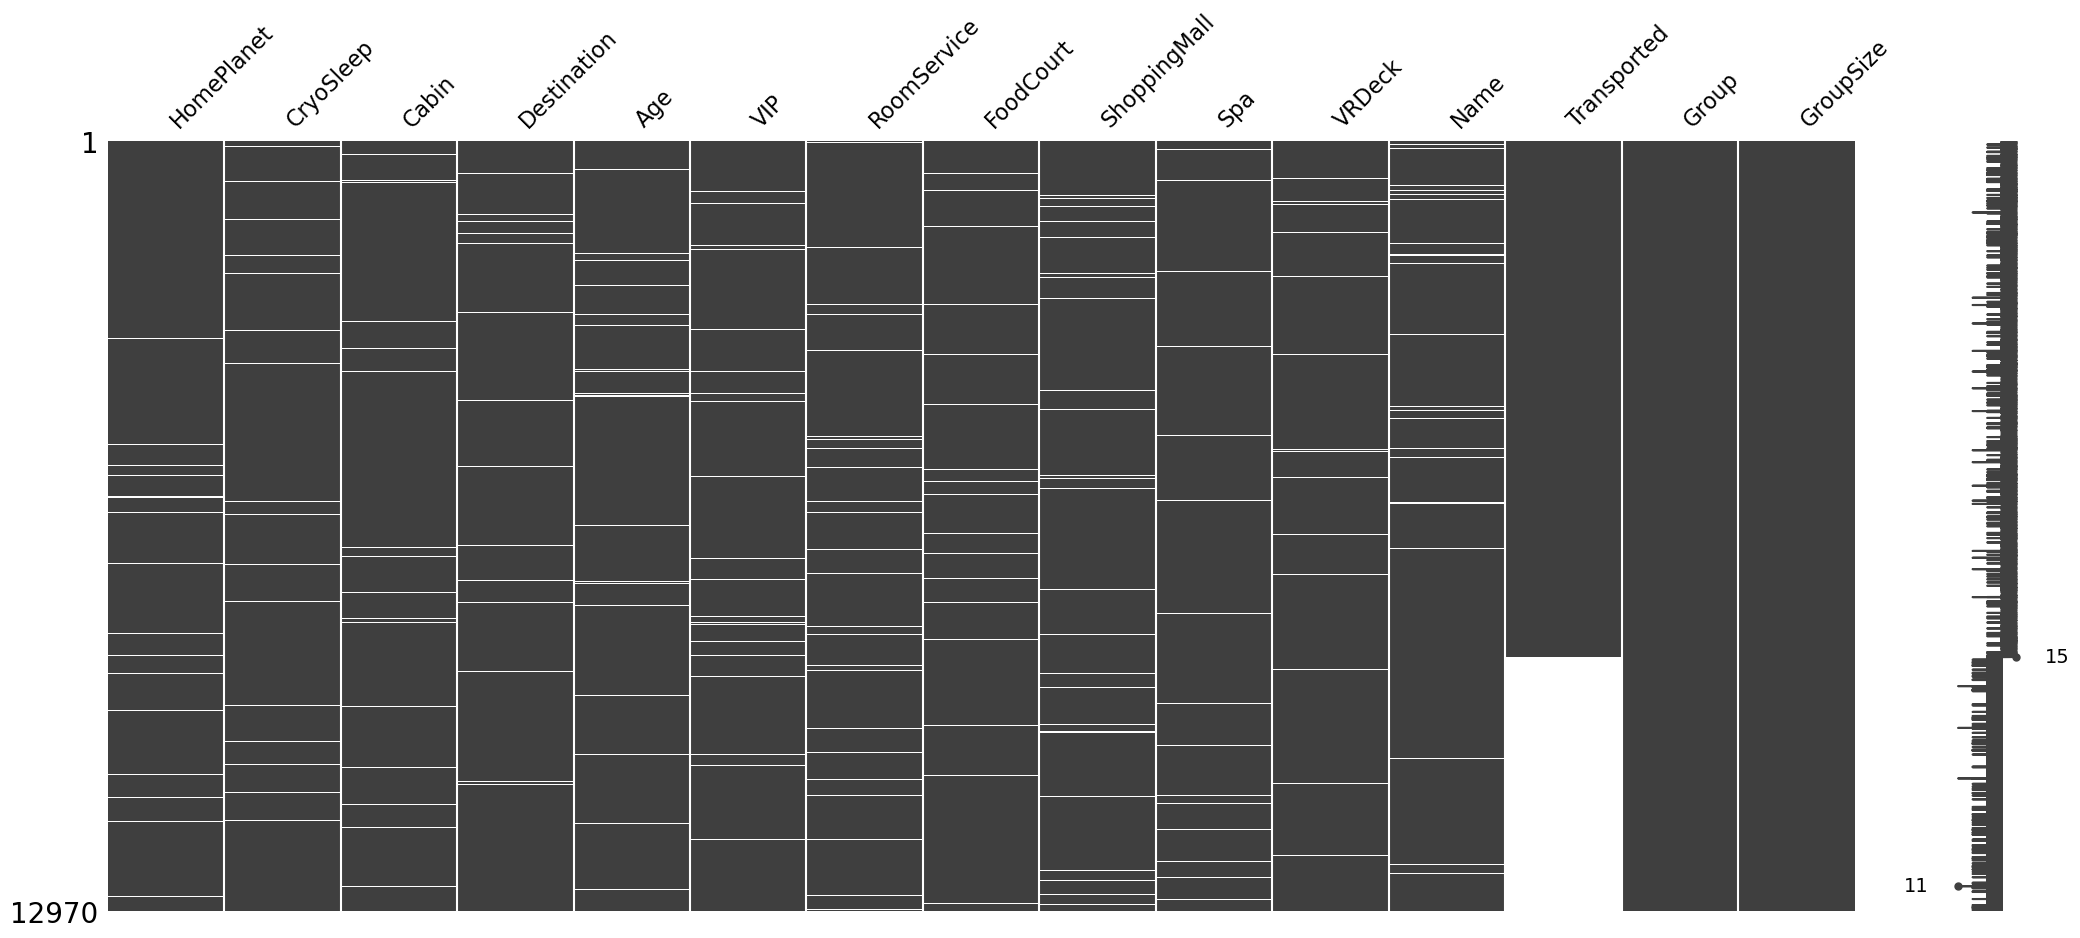

In [897]:
import missingno as msno
import matplotlib.pyplot as plt

# Print number of missing values in banking
print(data.isna().sum())

# Visualize missingness matrix
msno.matrix(data)
plt.show()

It seems that values are Missing At Random (Transported column is our target, it is missing in test data). We'll fill the missing values column by column, based on the description of the dataset.

**Name** - The first and last names of the passenger.

We don't need the first names, so we'll strip them. 
Additionally, we may assume that passengers with the same last names in different Groups are not relatives. To avoid treating them as relatives, we will append Group names to all last names:

In [898]:
### !!!! FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.

data.Name = data.Name.str.split(' ', 1).str[1]
data.Name = data.Name + data.Group

C:\Users\mikej\AppData\Local\Temp\ipykernel_28100\3279938100.py:3: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  data.Name = data.Name.str.split(' ', 1).str[1]


We'll fill the missing values for Names based on the most common surname in their Group.
If a passenger is alone in their group, we'll name them by the name of their Group:

In [899]:
# Iterate through all the rows with missing data
for index in data[data['Name'].isna()].index:
    # Fill the missing values for lonely passengers:
    if len(data[data['Group'] == data.loc[index, 'Group']]) == 1:
        data.loc[index, "Name"] = data.loc[index, 'Group']
    # Fill the missing values for non-lonely passengers:
    else:
        data.loc[index, "Name"] = data[(data['Group'] == data.loc[index, 'Group']) & \
                (data['Name'].isna() == False)]['Name'].mode()[0]

As you can see below, now Name doesn't have missing values:

In [900]:
print(data['Name'].info())
print(data['Name'].describe())
print('Unique Values:')
print(data['Name'].unique())

<class 'pandas.core.series.Series'>
RangeIndex: 12970 entries, 0 to 12969
Series name: Name
Non-Null Count  Dtype 
--------------  ----- 
12970 non-null  object
dtypes: object(1)
memory usage: 101.5+ KB
None
count              12970
unique              9691
top       Barnolderg6499
freq                   8
Name: Name, dtype: object
Unique Values:
['Ofracculy0001' 'Vines0002' 'Susent0003' ... 'Pore9271' 'Conale9273'
 'Leonzaley9277']


Since we don't have common Groups between train and test, we don't have common families as well. Hence, we'll just create FamilySize feature:

In [901]:
# Calculate FamilySize
data['FamilySize'] = data.groupby('Name')['Name'].transform('count')
print(data['FamilySize'].info())
print(data['FamilySize'].describe())
print('Unique Values:')
print(data['FamilySize'].unique())

<class 'pandas.core.series.Series'>
RangeIndex: 12970 entries, 0 to 12969
Series name: FamilySize
Non-Null Count  Dtype
--------------  -----
12970 non-null  int64
dtypes: int64(1)
memory usage: 101.5 KB
None
count    12970.000000
mean         1.803701
std          1.269773
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          8.000000
Name: FamilySize, dtype: float64
Unique Values:
[1 2 3 7 6 4 5 8]


In [902]:
# Add FamilySize to train and test

train['FamilySize'] = data.loc[:train_size-1, 'FamilySize'].values
test['FamilySize'] = data.loc[train_size:, 'FamilySize'].values
print('Unique Values in train:')
print(train['FamilySize'].unique())
print('Unique Values in test:')
print(test['FamilySize'].unique())

Unique Values in train:
[1 2 3 7 6 4 5 8]
Unique Values in test:
[1 2 3 5 4 6 7 8]


Note, that GroupSize is not always equal to FamilySize:

In [903]:
(train['GroupSize'] - train['FamilySize']).value_counts()

0    7727
1     533
2     202
3      91
4      70
5      40
6      22
7       8
dtype: int64

In [904]:
(test['GroupSize'] - test['FamilySize']).value_counts()

0    3832
1     208
2      95
3      57
4      43
5      30
6       9
7       3
dtype: int64

In [905]:
%%time

# Let's test

get_cv_scores(train, test, model_for_tests, scores_df, comment= "FamilySize")

scores_df

CPU times: total: 10.8 s
Wall time: 10.4 s


,Changes:,Train ROC AUC,Cross-val ROC AUC,Train Accuracy,Cross-val Accuracy,Test accuracy
0,Unprocessed numeric features,0.891046,0.847367,0.830047,0.790751,0.80056
1,GroupSize,0.899330,0.854434,0.828759,0.792477,NaN
2,FamilySize,0.900522,0.854035,0.828989,0.791787,NaN


Our cross-validation scores dropped. It may be due to the fact that GroupSize and Family Size are strongly correlated.

But what if we use only FamilySize, without GroupSize?

In [906]:
%%time

train = train.drop('GroupSize', axis=1)
test = test.drop('GroupSize', axis=1)


# Let's test

get_cv_scores(train, test, model_for_tests, scores_df, comment= "- GroupSize")

scores_df

CPU times: total: 7.94 s
Wall time: 10.2 s


,Changes:,Train ROC AUC,Cross-val ROC AUC,Train Accuracy,Cross-val Accuracy,Test accuracy
0,Unprocessed numeric features,0.891046,0.847367,0.830047,0.790751,0.80056
1,GroupSize,0.899330,0.854434,0.828759,0.792477,NaN
2,FamilySize,0.900522,0.854035,0.828989,0.791787,NaN
3,- GroupSize,0.896124,0.851555,0.829334,0.792938,NaN


Cross-val ROC AUC is higher for just GrouSize (Variant 01), so let's stick with it. 

In [907]:
# Revert train and test
train = train_unprocessed.select_dtypes(include=['int', 'float'])
test = test_unprocessed.select_dtypes(include=['int', 'float'])
train = pd.concat([train, train_unprocessed['Transported']], axis=1)
train = train.fillna(0)
test = test.fillna(0)
train['GroupSize'] = data.loc[:train_size-1, 'GroupSize'].values
test['GroupSize'] = data.loc[train_size:, 'GroupSize'].values

train.head()


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupSize
0,39.0,0.0,0.0,0.0,0.0,0.0,False,1
1,24.0,109.0,9.0,25.0,549.0,44.0,True,1
2,58.0,43.0,3576.0,0.0,6715.0,49.0,False,2
3,33.0,0.0,1283.0,371.0,3329.0,193.0,False,2
4,16.0,303.0,70.0,151.0,565.0,2.0,True,1


**HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.

**Destination** - The planet the passenger will be debarking to.

**VIP** - Whether the passenger has paid for special VIP service during the voyage.

**Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

It makes sense that these three features depend on Group and Name, so we'll fill the missing values accordingly. For lonely passengers, we'll fill these columns with the most common values.

We have two unique cases where the whole group has missing values. We'll fill them first:

In [908]:
data.loc[6917:6918, 'HomePlanet'] = data['HomePlanet'].mode()[0]
data.loc[5778:5779, 'VIP'] = data['VIP'].mode()[0]
data.loc[12941:12942, 'Cabin'] = data['Cabin'].mode()[0]

In [909]:
# List of columns with missing values
columns_to_fill = ['HomePlanet', 'Destination', 'VIP', 'Cabin']

# Iterate through all columns with missing values
for column in columns_to_fill:
    # Iterate through all the rows with missing data
    for index in data[data[column].isna()].index:
        # Fill the missing values for passengers alone in their group:
        if len(data[data['Group'] == data.loc[index, 'Group']]) == 1:
            data.loc[index, column] = data[column].mode()[0]
         # Fill the missing values for passengers with an unique last name:
        elif len(data[data['Name'] == data.loc[index, 'Name']]) == 1:
            data.loc[index, column] = data[(data['Group'] == data.loc[index, 'Group']) & \
                (data[column].isna() == False)][column].mode()[0]
        # Fill the missing values for non-lonely passengers:
        else:
            data.loc[index, column] = data[(data['Group'] == data.loc[index, 'Group']) & \
                            (data['Name'] == data.loc[index, 'Name']) & \
                            (data[column].isna() == False)][column].mode()[0]

Let's check the filled columns:

In [910]:
for column in columns_to_fill:
    print(data[column].info())
    print(data[column].describe())
    print('Unique Values:')
    print(data[column].unique())

<class 'pandas.core.series.Series'>
RangeIndex: 12970 entries, 0 to 12969
Series name: HomePlanet
Non-Null Count  Dtype 
--------------  ----- 
12970 non-null  object
dtypes: object(1)
memory usage: 101.5+ KB
None
count     12970
unique        3
top       Earth
freq       7071
Name: HomePlanet, dtype: object
Unique Values:
['Europa' 'Earth' 'Mars']
<class 'pandas.core.series.Series'>
RangeIndex: 12970 entries, 0 to 12969
Series name: Destination
Non-Null Count  Dtype 
--------------  ----- 
12970 non-null  object
dtypes: object(1)
memory usage: 101.5+ KB
None
count           12970
unique              3
top       TRAPPIST-1e
freq             9106
Name: Destination, dtype: object
Unique Values:
['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e']
<class 'pandas.core.series.Series'>
RangeIndex: 12970 entries, 0 to 12969
Series name: VIP
Non-Null Count  Dtype 
--------------  ----- 
12970 non-null  object
dtypes: object(1)
memory usage: 101.5+ KB
None
count     12970
unique        2
top       Fal

Everything is good now, the first three columns are ready for encoding to numericals, but we want to extract the useful data from Cabin.

**Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

Let's extract Deck and Side, and drop Cabin:

In [911]:
data['Deck'] = data.Cabin.str[0]
data['Side'] = data.Cabin.str[-1]

data = data.drop('Cabin', axis=1)

for column in ['Deck', 'Side']:
    print(data[column].info())
    print(data[column].describe())
    print('Unique Values:')
    print(data[column].unique())

<class 'pandas.core.series.Series'>
RangeIndex: 12970 entries, 0 to 12969
Series name: Deck
Non-Null Count  Dtype 
--------------  ----- 
12970 non-null  object
dtypes: object(1)
memory usage: 101.5+ KB
None
count     12970
unique        8
top           F
freq       4268
Name: Deck, dtype: object
Unique Values:
['B' 'F' 'A' 'G' 'E' 'D' 'C' 'T']
<class 'pandas.core.series.Series'>
RangeIndex: 12970 entries, 0 to 12969
Series name: Side
Non-Null Count  Dtype 
--------------  ----- 
12970 non-null  object
dtypes: object(1)
memory usage: 101.5+ KB
None
count     12970
unique        2
top           P
freq       6516
Name: Side, dtype: object
Unique Values:
['P' 'S']


Seems great. Now, we may assume that Decks are labeled based on their position in the spacehip, so we can label them with numbers:

In [912]:
# Label encoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['Deck_enc'] = le.fit_transform(data['Deck'])

data[['Deck', 'Deck_enc']].head()


,Deck,Deck_enc
0,B,1
1,F,5
2,A,0
3,A,0
4,F,5


Let's try this new feature:

In [913]:
%%time

train['Deck_enc'] = data.loc[:train_size-1, 'Deck_enc'].values
test['Deck_enc'] = data.loc[train_size:, 'Deck_enc'].values

# Let's test

submission_04 = get_cv_scores(train, test, model_for_tests, scores_df, comment= "1 + Deck_enc", prepare_submission=True)

scores_df


CPU times: total: 11.4 s
Wall time: 10.7 s


,Changes:,Train ROC AUC,Cross-val ROC AUC,Train Accuracy,Cross-val Accuracy,Test accuracy
0,Unprocessed numeric features,0.891046,0.847367,0.830047,0.790751,0.80056
1,GroupSize,0.899330,0.854434,0.828759,0.792477,NaN
2,FamilySize,0.900522,0.854035,0.828989,0.791787,NaN
3,- GroupSize,0.896124,0.851555,0.829334,0.792938,NaN
4,1 + Deck_enc,0.927033,0.877194,0.831174,0.791672,NaN


Cross-val ROC AUC score increased, but Cross-val Accuracy decreased. We'll prioritize for ROC AUC, since it will be more important in a long run.
Also, we won't take into account Test accuracy, since we want our model to generalize well to unknown data. We'll use test accuracy only to test if our cross-validation is not bugged:

In [914]:
submission_04.to_csv('04_submission_04.csv', index=False)

scores_df.loc[4, 'Test accuracy'] = 0.79682

scores_df

,Changes:,Train ROC AUC,Cross-val ROC AUC,Train Accuracy,Cross-val Accuracy,Test accuracy
0,Unprocessed numeric features,0.891046,0.847367,0.830047,0.790751,0.80056
1,GroupSize,0.899330,0.854434,0.828759,0.792477,NaN
2,FamilySize,0.900522,0.854035,0.828989,0.791787,NaN
3,- GroupSize,0.896124,0.851555,0.829334,0.792938,NaN
4,1 + Deck_enc,0.927033,0.877194,0.831174,0.791672,0.79682


Test accuracy decreased, but we'll keep Deck, since we prioritize for Cross-val ROC AUC.

In [915]:
train.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupSize,Deck_enc
0,39.0,0.0,0.0,0.0,0.0,0.0,False,1,1
1,24.0,109.0,9.0,25.0,549.0,44.0,True,1,5
2,58.0,43.0,3576.0,0.0,6715.0,49.0,False,2,0
3,33.0,0.0,1283.0,371.0,3329.0,193.0,False,2,0
4,16.0,303.0,70.0,151.0,565.0,2.0,True,1,5


**CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

I suspect that CryoSleep may be dependend on HomePlanet and Destination. Let's check:

In [916]:
pd.pivot_table(data, values='CryoSleep', index=['HomePlanet'], columns=["Destination"])

Destination,55 Cancri e,PSO J318.5-22,TRAPPIST-1e
HomePlanet,,,
Earth,0.317317,0.508364,0.263049
Europa,0.514111,0.551724,0.401938
Mars,0.419795,0.227273,0.396701


In [917]:
# Iterate through all the rows with missing data
for index in data[data['CryoSleep'].isna()].index:
    # Fill the missing values:
    data.loc[index, "CryoSleep"] = data[(data['HomePlanet'] == data.loc[index, 'HomePlanet']) & \
                                        (data['Destination'] == data.loc[index, 'Destination']) & \
                            (data['CryoSleep'].isna() == False)]['CryoSleep'].mode()[0]
    
print(data['CryoSleep'].info())
print(data['CryoSleep'].describe())
print('Unique Values:')
print(data['CryoSleep'].unique())

<class 'pandas.core.series.Series'>
RangeIndex: 12970 entries, 0 to 12969
Series name: CryoSleep
Non-Null Count  Dtype 
--------------  ----- 
12970 non-null  object
dtypes: object(1)
memory usage: 101.5+ KB
None
count     12970
unique        2
top       False
freq       8333
Name: CryoSleep, dtype: object
Unique Values:
[False True]


Let's look at the current results of the validation and cleaning:

In [918]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    12970 non-null  object 
 1   CryoSleep     12970 non-null  object 
 2   Destination   12970 non-null  object 
 3   Age           12700 non-null  float64
 4   VIP           12970 non-null  object 
 5   RoomService   12707 non-null  float64
 6   FoodCourt     12681 non-null  float64
 7   ShoppingMall  12664 non-null  float64
 8   Spa           12686 non-null  float64
 9   VRDeck        12702 non-null  float64
 10  Name          12970 non-null  object 
 11  Transported   8693 non-null   object 
 12  Group         12970 non-null  object 
 13  GroupSize     12970 non-null  int64  
 14  FamilySize    12970 non-null  int64  
 15  Deck          12970 non-null  object 
 16  Side          12970 non-null  object 
 17  Deck_enc      12970 non-null  int32  
dtypes: float64(6), int32(1), i

No categorical columns have missing values (missing values in Transported correspond to the testing set).

Now, let's create dummy variables for categorical data that we haven't tried to incorporate yet and test if they benefit our performance:

In [919]:
dummies = pd.get_dummies(data["HomePlanet"], drop_first=True)
data = pd.concat([data, dummies], axis = 1)
train = pd.concat([train, dummies.loc[:train_size-1, :]], axis = 1)
test = pd.concat([test, dummies.loc[train_size:, :].reset_index(drop=True)], axis = 1)

train.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupSize,Deck_enc,Europa,Mars
0,39.0,0.0,0.0,0.0,0.0,0.0,False,1,1,1,0
1,24.0,109.0,9.0,25.0,549.0,44.0,True,1,5,0,0
2,58.0,43.0,3576.0,0.0,6715.0,49.0,False,2,0,1,0
3,33.0,0.0,1283.0,371.0,3329.0,193.0,False,2,0,1,0
4,16.0,303.0,70.0,151.0,565.0,2.0,True,1,5,0,0


In [920]:
test.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,GroupSize,Deck_enc,Europa,Mars
0,27.0,0.0,0.0,0.0,0.0,0.0,1,6,0,0
1,19.0,0.0,9.0,0.0,2823.0,0.0,1,5,0,0
2,31.0,0.0,0.0,0.0,0.0,0.0,1,2,1,0
3,38.0,0.0,6652.0,0.0,181.0,585.0,1,2,1,0
4,20.0,10.0,0.0,635.0,0.0,0.0,1,5,0,0


In [921]:
%%time

# Let's test
get_cv_scores(train, test, model_for_tests, scores_df, comment= "+ HomePlanet")

scores_df


CPU times: total: 26.9 s
Wall time: 11.2 s


,Changes:,Train ROC AUC,Cross-val ROC AUC,Train Accuracy,Cross-val Accuracy,Test accuracy
0,Unprocessed numeric features,0.891046,0.847367,0.830047,0.790751,0.80056
1,GroupSize,0.899330,0.854434,0.828759,0.792477,NaN
2,FamilySize,0.900522,0.854035,0.828989,0.791787,NaN
3,- GroupSize,0.896124,0.851555,0.829334,0.792938,NaN
4,1 + Deck_enc,0.927033,0.877194,0.831174,0.791672,0.79682
5,+ HomePlanet,0.930021,0.880737,0.834349,0.794893,NaN


In [922]:
dummies = pd.get_dummies(data["Destination"], drop_first=True)
data = pd.concat([data, dummies], axis = 1)
train = pd.concat([train, dummies.loc[:train_size-1, :]], axis = 1)
test = pd.concat([test, dummies.loc[train_size:, :].reset_index(drop=True)], axis = 1)

test.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,GroupSize,Deck_enc,Europa,Mars,PSO J318.5-22,TRAPPIST-1e
0,27.0,0.0,0.0,0.0,0.0,0.0,1,6,0,0,0,1
1,19.0,0.0,9.0,0.0,2823.0,0.0,1,5,0,0,0,1
2,31.0,0.0,0.0,0.0,0.0,0.0,1,2,1,0,0,0
3,38.0,0.0,6652.0,0.0,181.0,585.0,1,2,1,0,0,1
4,20.0,10.0,0.0,635.0,0.0,0.0,1,5,0,0,0,1


In [923]:
%%time

get_cv_scores(train, test, model_for_tests, scores_df, comment= "+ Destination", prepare_submission=True)

scores_df

CPU times: total: 23.1 s
Wall time: 11.2 s


,Changes:,Train ROC AUC,Cross-val ROC AUC,Train Accuracy,Cross-val Accuracy,Test accuracy
0,Unprocessed numeric features,0.891046,0.847367,0.830047,0.790751,0.80056
1,GroupSize,0.899330,0.854434,0.828759,0.792477,NaN
2,FamilySize,0.900522,0.854035,0.828989,0.791787,NaN
3,- GroupSize,0.896124,0.851555,0.829334,0.792938,NaN
4,1 + Deck_enc,0.927033,0.877194,0.831174,0.791672,0.79682
5,+ HomePlanet,0.930021,0.880737,0.834349,0.794893,NaN
6,+ Destination,0.930903,0.882469,0.835431,0.796503,NaN


Cross-val scores are up, Destination stays. Next:

In [924]:
data["CryoSleep"] = [1 if i else 0 for i in data["CryoSleep"]]
train = pd.concat([train, data.loc[:train_size-1, "CryoSleep"]], axis = 1)
test = pd.concat([test, data.loc[train_size:, "CryoSleep"].reset_index(drop=True)], axis = 1)

test.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,GroupSize,Deck_enc,Europa,Mars,PSO J318.5-22,TRAPPIST-1e,CryoSleep
0,27.0,0.0,0.0,0.0,0.0,0.0,1,6,0,0,0,1,1
1,19.0,0.0,9.0,0.0,2823.0,0.0,1,5,0,0,0,1,0
2,31.0,0.0,0.0,0.0,0.0,0.0,1,2,1,0,0,0,1
3,38.0,0.0,6652.0,0.0,181.0,585.0,1,2,1,0,0,1,0
4,20.0,10.0,0.0,635.0,0.0,0.0,1,5,0,0,0,1,0


In [925]:
%%time

get_cv_scores(train, test, model_for_tests, scores_df, comment= "+ CryoSleep", prepare_submission=True)

scores_df

CPU times: total: 40.8 s
Wall time: 12.6 s


,Changes:,Train ROC AUC,Cross-val ROC AUC,Train Accuracy,Cross-val Accuracy,Test accuracy
0,Unprocessed numeric features,0.891046,0.847367,0.830047,0.790751,0.80056
1,GroupSize,0.899330,0.854434,0.828759,0.792477,NaN
2,FamilySize,0.900522,0.854035,0.828989,0.791787,NaN
3,- GroupSize,0.896124,0.851555,0.829334,0.792938,NaN
4,1 + Deck_enc,0.927033,0.877194,0.831174,0.791672,0.79682
5,+ HomePlanet,0.930021,0.880737,0.834349,0.794893,NaN
6,+ Destination,0.930903,0.882469,0.835431,0.796503,NaN
7,+ CryoSleep,0.931807,0.882508,0.838951,0.799264,NaN


Cross-val scores are up, CryoSleep stays. Next:

In [926]:
%%time

data["VIP"] = [1 if i else 0 for i in data["VIP"]]
train = pd.concat([train, data.loc[:train_size-1, "VIP"]], axis = 1)
test = pd.concat([test, data.loc[train_size:, "VIP"].reset_index(drop=True)], axis = 1)

get_cv_scores(train, test, model_for_tests, scores_df, comment= "+ VIP", prepare_submission=True)

scores_df

CPU times: total: 35.1 s
Wall time: 11.8 s


,Changes:,Train ROC AUC,Cross-val ROC AUC,Train Accuracy,Cross-val Accuracy,Test accuracy
0,Unprocessed numeric features,0.891046,0.847367,0.830047,0.790751,0.80056
1,GroupSize,0.899330,0.854434,0.828759,0.792477,NaN
2,FamilySize,0.900522,0.854035,0.828989,0.791787,NaN
3,- GroupSize,0.896124,0.851555,0.829334,0.792938,NaN
4,1 + Deck_enc,0.927033,0.877194,0.831174,0.791672,0.79682
5,+ HomePlanet,0.930021,0.880737,0.834349,0.794893,NaN
6,+ Destination,0.930903,0.882469,0.835431,0.796503,NaN
7,+ CryoSleep,0.931807,0.882508,0.838951,0.799264,NaN
8,+ VIP,0.931491,0.882599,0.838790,0.799724,NaN


Cross-val scores are up, VIP stays. Next:

In [927]:
dummies = pd.get_dummies(data["Side"], drop_first=True)
data = pd.concat([data, dummies], axis = 1)
train = pd.concat([train, dummies.loc[:train_size-1, :]], axis = 1)
test = pd.concat([test, dummies.loc[train_size:, :].reset_index(drop=True)], axis = 1)

test.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,GroupSize,Deck_enc,Europa,Mars,PSO J318.5-22,TRAPPIST-1e,CryoSleep,VIP,S
0,27.0,0.0,0.0,0.0,0.0,0.0,1,6,0,0,0,1,1,0,1
1,19.0,0.0,9.0,0.0,2823.0,0.0,1,5,0,0,0,1,0,0,1
2,31.0,0.0,0.0,0.0,0.0,0.0,1,2,1,0,0,0,1,0,1
3,38.0,0.0,6652.0,0.0,181.0,585.0,1,2,1,0,0,1,0,0,1
4,20.0,10.0,0.0,635.0,0.0,0.0,1,5,0,0,0,1,0,0,1


In [928]:
%%time

get_cv_scores(train, test, model_for_tests, scores_df, comment= "+ Side", prepare_submission=False)

scores_df

CPU times: total: 39.5 s
Wall time: 11.5 s


,Changes:,Train ROC AUC,Cross-val ROC AUC,Train Accuracy,Cross-val Accuracy,Test accuracy
0,Unprocessed numeric features,0.891046,0.847367,0.830047,0.790751,0.80056
1,GroupSize,0.899330,0.854434,0.828759,0.792477,NaN
2,FamilySize,0.900522,0.854035,0.828989,0.791787,NaN
3,- GroupSize,0.896124,0.851555,0.829334,0.792938,NaN
4,1 + Deck_enc,0.927033,0.877194,0.831174,0.791672,0.79682
5,+ HomePlanet,0.930021,0.880737,0.834349,0.794893,NaN
6,+ Destination,0.930903,0.882469,0.835431,0.796503,NaN
7,+ CryoSleep,0.931807,0.882508,0.838951,0.799264,NaN
8,+ VIP,0.931491,0.882599,0.838790,0.799724,NaN
9,+ Side,0.934370,0.886205,0.844196,0.799379,NaN


Cross-val ROC AUC is up, so Side stays. We are done with incorporating categorical features. Only Family size didn't improve our score.

What if we create a feature HasRelatives, with 1 for those who have Family size > 1, and zeros for others?

In [929]:
%%time

data["HasRelatives"] = [1 if i > 1 else 0 for i in data["FamilySize"]]
train = pd.concat([train, data.loc[:train_size-1, "HasRelatives"]], axis = 1)
test = pd.concat([test, data.loc[train_size:, "HasRelatives"].reset_index(drop=True)], axis = 1)

submission_10 = get_cv_scores(train, test, model_for_tests, scores_df, comment= "+ HasRelatives", prepare_submission=True)


CPU times: total: 44.6 s
Wall time: 11.9 s


In [930]:
submission_10.to_csv('04_submission_10.csv', index=False)

scores_df.loc[10, 'Test accuracy'] = 0.80079

scores_df

,Changes:,Train ROC AUC,Cross-val ROC AUC,Train Accuracy,Cross-val Accuracy,Test accuracy
0,Unprocessed numeric features,0.891046,0.847367,0.830047,0.790751,0.80056
1,GroupSize,0.899330,0.854434,0.828759,0.792477,NaN
2,FamilySize,0.900522,0.854035,0.828989,0.791787,NaN
3,- GroupSize,0.896124,0.851555,0.829334,0.792938,NaN
4,1 + Deck_enc,0.927033,0.877194,0.831174,0.791672,0.79682
5,+ HomePlanet,0.930021,0.880737,0.834349,0.794893,NaN
6,+ Destination,0.930903,0.882469,0.835431,0.796503,NaN
7,+ CryoSleep,0.931807,0.882508,0.838951,0.799264,NaN
8,+ VIP,0.931491,0.882599,0.838790,0.799724,NaN
9,+ Side,0.934370,0.886205,0.844196,0.799379,NaN


Cross-val ROC AUC went down, so we won't use HasRelatives. Now we have 15 fetures:

In [931]:
train = train.drop('HasRelatives', axis=1)
test = test.drop('HasRelatives', axis=1)

test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Age            4277 non-null   float64
 1   RoomService    4277 non-null   float64
 2   FoodCourt      4277 non-null   float64
 3   ShoppingMall   4277 non-null   float64
 4   Spa            4277 non-null   float64
 5   VRDeck         4277 non-null   float64
 6   GroupSize      4277 non-null   int64  
 7   Deck_enc       4277 non-null   int32  
 8   Europa         4277 non-null   uint8  
 9   Mars           4277 non-null   uint8  
 10  PSO J318.5-22  4277 non-null   uint8  
 11  TRAPPIST-1e    4277 non-null   uint8  
 12  CryoSleep      4277 non-null   int64  
 13  VIP            4277 non-null   int64  
 14  S              4277 non-null   uint8  
dtypes: float64(6), int32(1), int64(3), uint8(5)
memory usage: 338.4 KB


### Numerical features

At the beginning of Part 4, we filled missing values in our numerical features with 0's. 

What if we try more elaborate filling strategies?

**RoomService, FoodCourt, ShoppingMall, Spa, VRDeck** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

Almost all passengers with CryoSleep == True do not spend money on servises. Here is the 99th quantiles:

In [932]:
print(data[data['CryoSleep'] == 1].quantile(0.99, numeric_only=True))

CryoSleep         1.0
Age              65.0
VIP               0.0
RoomService       0.0
FoodCourt         0.0
ShoppingMall      0.0
Spa               0.0
VRDeck            0.0
GroupSize         8.0
FamilySize        7.0
Deck_enc          6.0
Europa            1.0
Mars              1.0
PSO J318.5-22     1.0
TRAPPIST-1e       1.0
S                 1.0
HasRelatives      1.0
Name: 0.99, dtype: float64


Therefore, we can fill missing values with 0's for such passengers.

In [933]:
# Collect unprocessed "Age" to train and test
train['Age'] = train_unprocessed['Age']
test['Age'] = test_unprocessed['Age']

# For each category of spendings
for column in ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']:
    # Collect unprocessed columns to train and test
    train[column] = train_unprocessed[column]
    test[column] = test_unprocessed[column]
    # Zeros for passengers in CryoSleep
    train.loc[train['CryoSleep'] == True, column].fillna(0, inplace = True)
    test.loc[test['CryoSleep'] == True, column].fillna(0, inplace = True)

print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Age            8514 non-null   float64
 1   RoomService    8512 non-null   float64
 2   FoodCourt      8510 non-null   float64
 3   ShoppingMall   8485 non-null   float64
 4   Spa            8510 non-null   float64
 5   VRDeck         8505 non-null   float64
 6   Transported    8693 non-null   bool   
 7   GroupSize      8693 non-null   int64  
 8   Deck_enc       8693 non-null   int32  
 9   Europa         8693 non-null   uint8  
 10  Mars           8693 non-null   uint8  
 11  PSO J318.5-22  8693 non-null   uint8  
 12  TRAPPIST-1e    8693 non-null   uint8  
 13  CryoSleep      8693 non-null   int64  
 14  VIP            8693 non-null   int64  
 15  S              8693 non-null   uint8  
dtypes: bool(1), float64(6), int32(1), int64(3), uint8(5)
memory usage: 696.2 KB
None


How about prices for services of VIP vs not VIP?

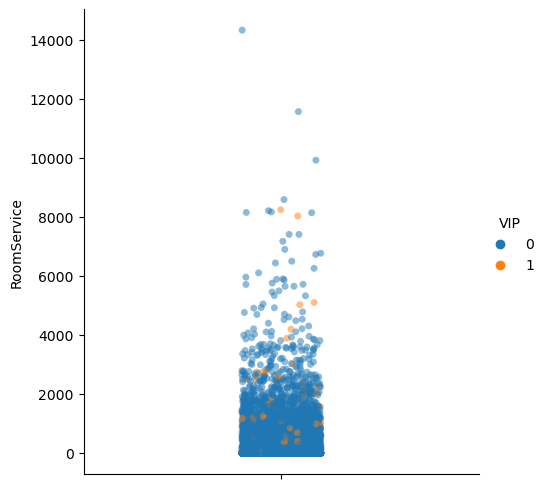

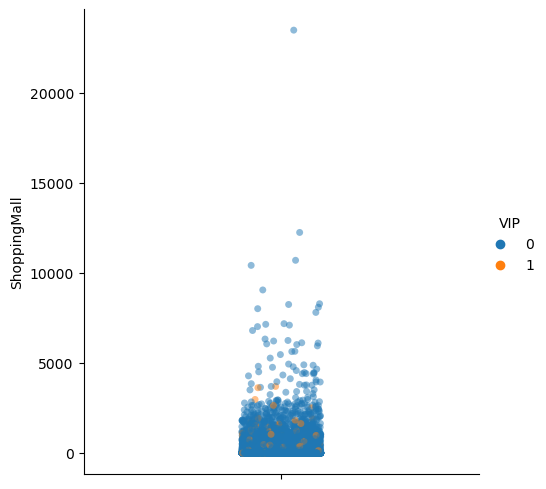

In [934]:
import seaborn as sns

sns.catplot(data=data, y='RoomService', hue='VIP', alpha = 0.5)
sns.catplot(data=data, y='ShoppingMall', hue='VIP', alpha = 0.5)

It seems that VIP status doesn't affect spendings much. Let's look for other correlations, but first let's introduce feature Total Spendings:

In [935]:
train['TotalSpendings'] = train[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'GroupSize']].sum(axis=1)
test['TotalSpendings'] = test[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'GroupSize']].sum(axis=1)

print(train['TotalSpendings'].info())
train['TotalSpendings'].describe()

<class 'pandas.core.series.Series'>
RangeIndex: 8693 entries, 0 to 8692
Series name: TotalSpendings
Non-Null Count  Dtype  
--------------  -----  
8693 non-null   float64
dtypes: float64(1)
memory usage: 68.0 KB
None


count     8693.000000
mean      1442.901875
std       2803.065832
min          1.000000
25%          2.000000
50%        718.000000
75%       1443.000000
max      35988.000000
Name: TotalSpendings, dtype: float64

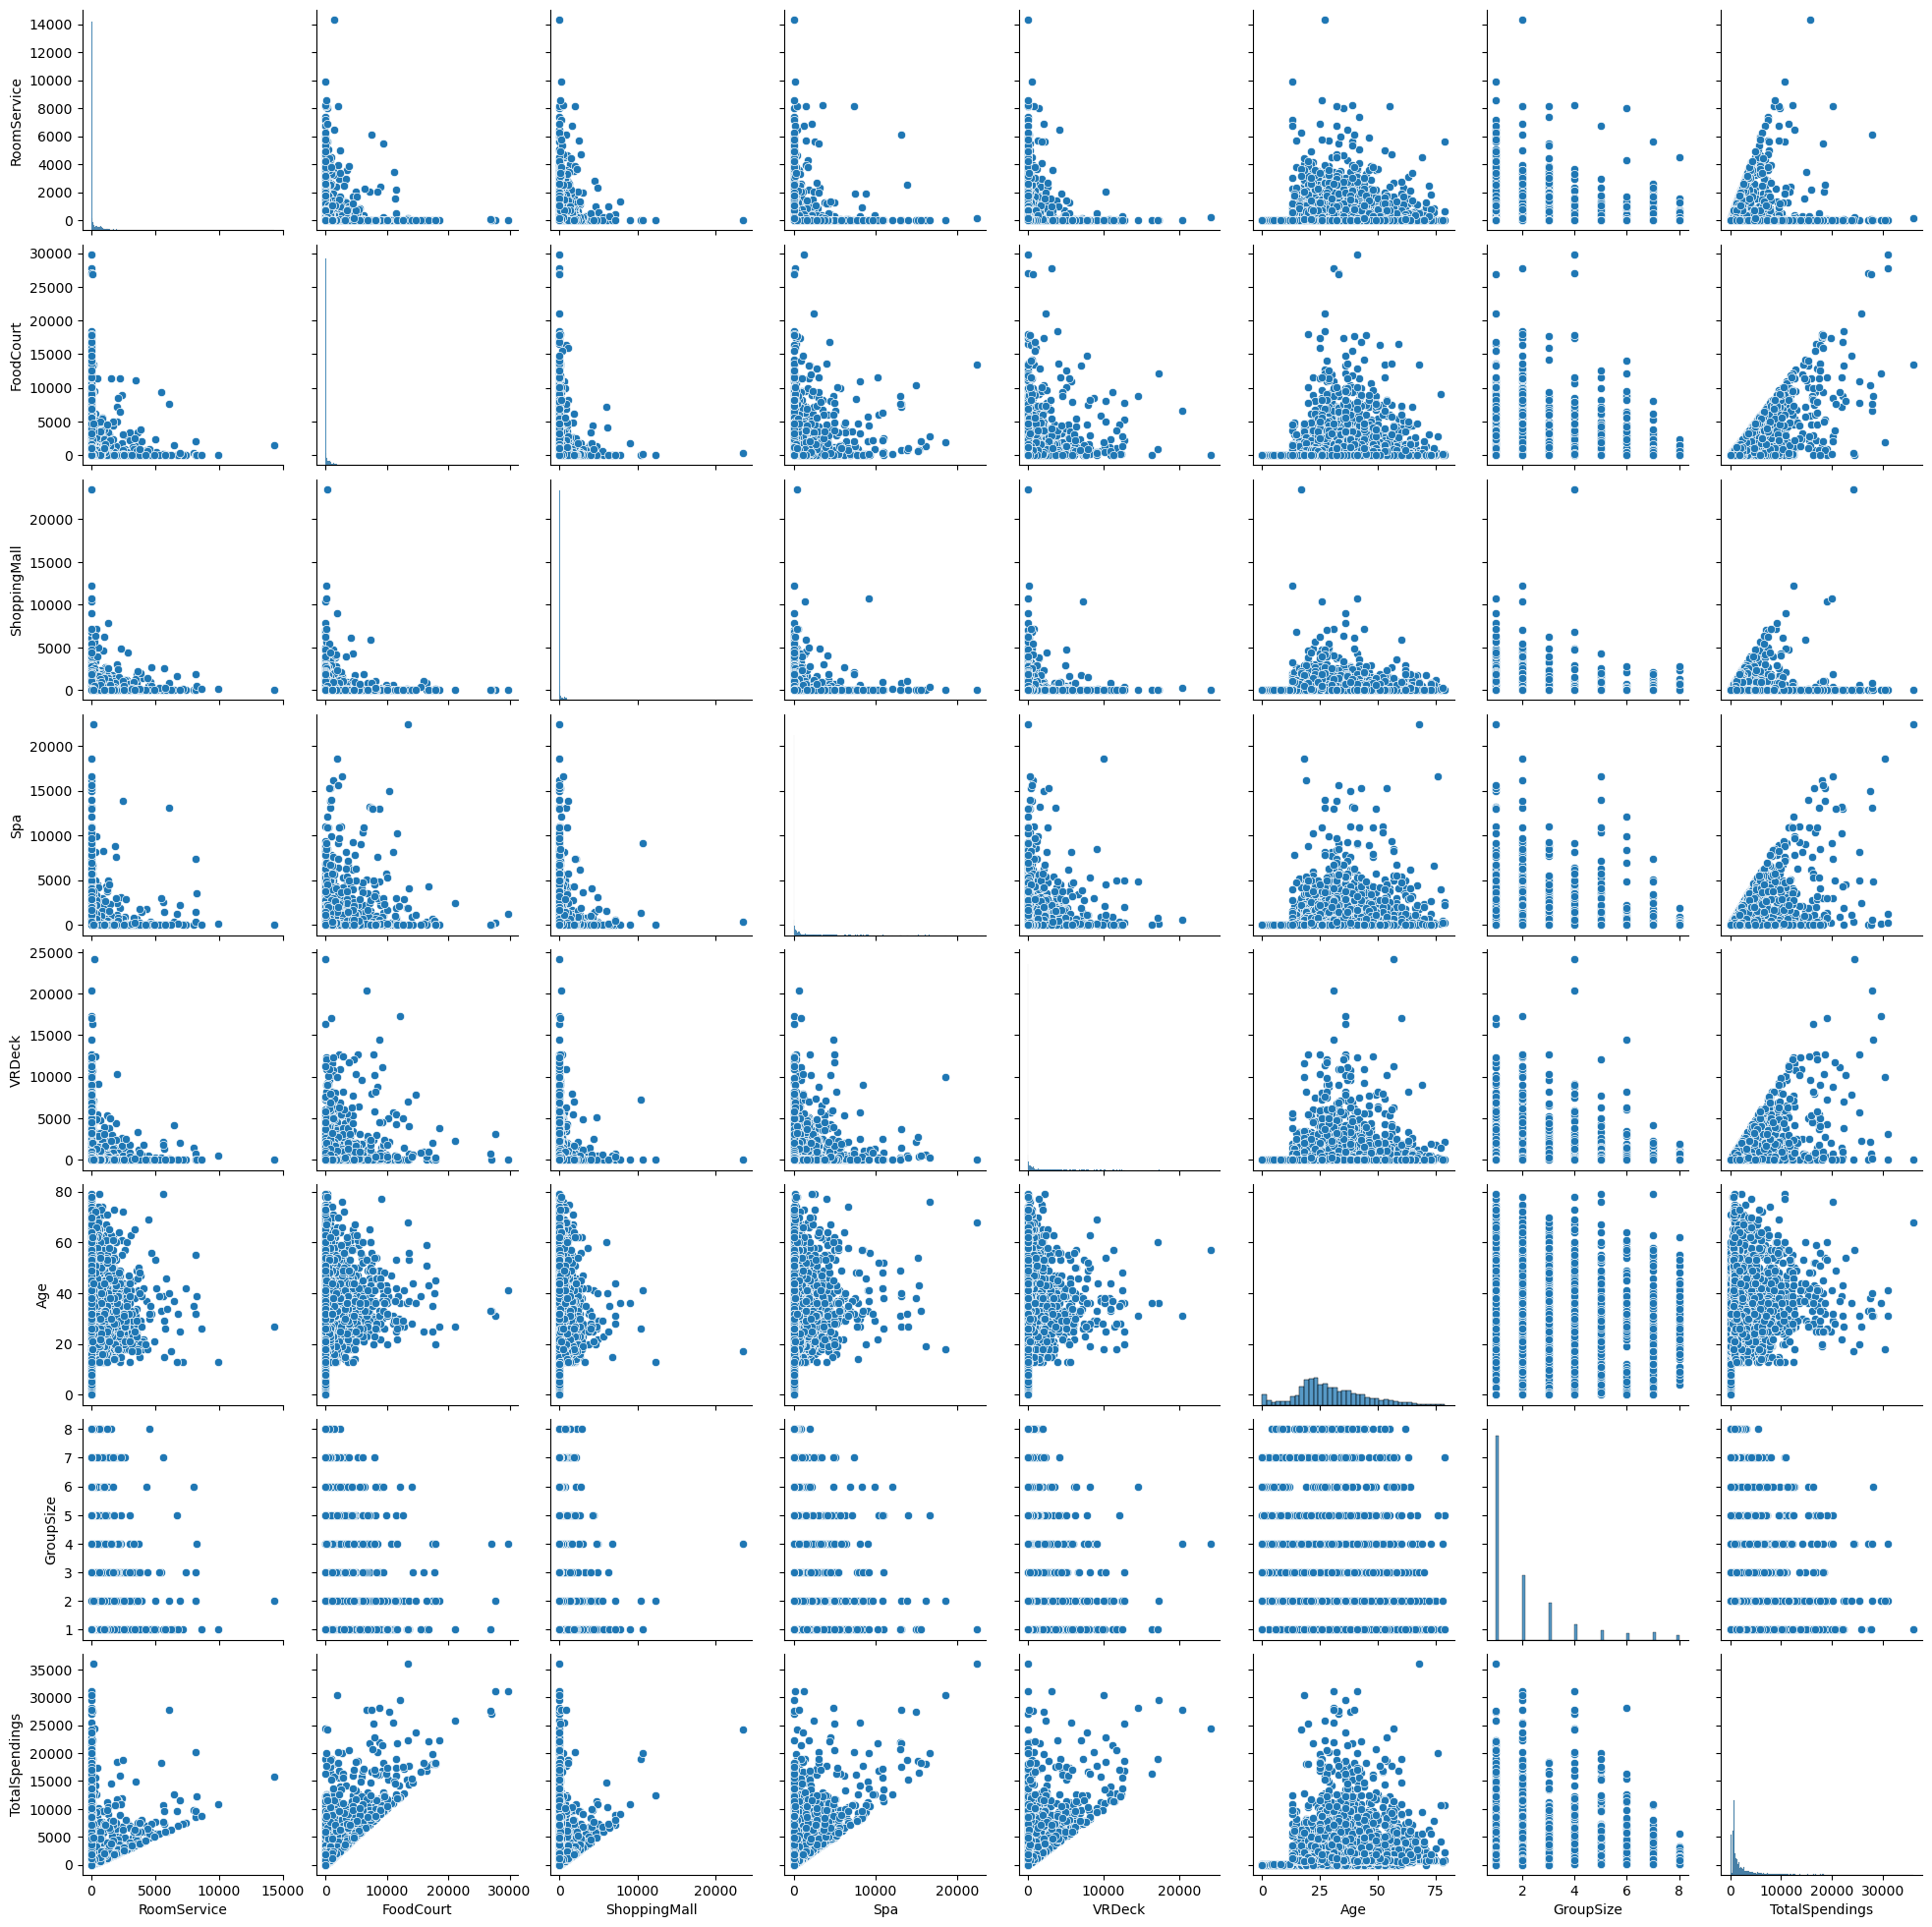

CPU times: total: 17 s
Wall time: 19 s


In [936]:
%%time

import matplotlib.pyplot as plt

# Plot pairwise relationships
sns.pairplot(train.loc[train['CryoSleep'] == False, ['RoomService', 'FoodCourt', \
                                                    'ShoppingMall', 'Spa', 'VRDeck', \
                                                    'Age', 'GroupSize', 'TotalSpendings']])

# Show plot
plt.show()

First, we see that spendings in different categories don't really corelate with each other or with TotalSpendings.

However, we see that all of them show the same pattern with Age. Let's look at this pattern more closely:

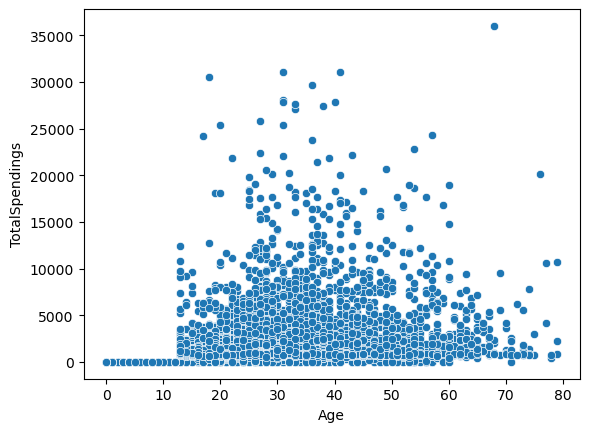

In [937]:
# Plot pairwise relationships
sns.scatterplot(data = train[train['CryoSleep'] == False], x='Age', y='TotalSpendings')

# Show plot
plt.show()

In [938]:
train.groupby('Age')['TotalSpendings'].mean().head(16)

Age
0.0        3.696629
1.0        4.104478
2.0        3.853333
3.0        4.160000
4.0        3.887324
5.0        3.636364
6.0        3.325000
7.0        3.807692
8.0        3.869565
9.0        4.238095
10.0       3.205128
11.0       4.127660
12.0       3.731707
13.0    1117.156028
14.0     665.347826
15.0     774.264516
Name: TotalSpendings, dtype: float64

We see that middle-aged spend more than young and old;


1) We'll fill missing spendings according to mean spendings for their Age (calculated on the train set, to prevent data leakage)

2) We'll recalculate TotalSpendings

2) We'll fill missing Age values according to their TotalSpendings (calculated on the train set, to prevent data leakage)

Let's procceed:

In [943]:
# fill missing spendings according to mean spendings for their Age

# For each category of spendings in train
for column in ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']:
    
    # If Age is missing, fill with mean spendings
    train.loc[train['Age'].isna(), column] = train[column].mean()
    test.loc[test['Age'].isna(), column] = train[column].mean()
    
    # Iterate through all the rows with missing data
    for index in train[train[column].isna()].index:
        # If Age is present, fill with mean spendings for their Age
        train.loc[index, column] = train.loc[train['Age'] == train.loc[index, "Age"]][column].mean()
            
    print(train[column].info())
    print(train[column].describe())
    
    # Iterate through all the rows with missing data
    for index in test[test[column].isna()].index:
        # If Age is present, fill with mean spendings for their Age
        test.loc[index, column] = train.loc[train['Age'] == test.loc[index, "Age"]][column].mean()
            
    print(test[column].info())
    print(test[column].describe())
    


<class 'pandas.core.series.Series'>
RangeIndex: 8693 entries, 0 to 8692
Series name: RoomService
Non-Null Count  Dtype  
--------------  -----  
8693 non-null   float64
dtypes: float64(1)
memory usage: 68.0 KB
None
count     8693.000000
mean       225.650815
std        656.463618
min          0.000000
25%          0.000000
50%          0.000000
75%        114.000000
max      14327.000000
Name: RoomService, dtype: float64
<class 'pandas.core.series.Series'>
RangeIndex: 4277 entries, 0 to 4276
Series name: RoomService
Non-Null Count  Dtype  
--------------  -----  
4277 non-null   float64
dtypes: float64(1)
memory usage: 33.5 KB
None
count     4277.000000
mean       219.390420
std        593.108969
min          0.000000
25%          0.000000
50%          0.000000
75%        115.000000
max      11567.000000
Name: RoomService, dtype: float64
<class 'pandas.core.series.Series'>
RangeIndex: 8693 entries, 0 to 8692
Series name: FoodCourt
Non-Null Count  Dtype  
--------------  -----  
8693 no

In [944]:
# recalculate TotalSpendings

train['TotalSpendings'] = train[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'GroupSize']].sum(axis=1)
test['TotalSpendings'] = test[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'GroupSize']].sum(axis=1)

print(train['TotalSpendings'].info())
print(train['TotalSpendings'].describe())

print(test['TotalSpendings'].info())
test['TotalSpendings'].describe()


<class 'pandas.core.series.Series'>
RangeIndex: 8693 entries, 0 to 8692
Series name: TotalSpendings
Non-Null Count  Dtype  
--------------  -----  
8693 non-null   float64
dtypes: float64(1)
memory usage: 68.0 KB
None
count     8693.000000
mean      1478.976386
std       2775.123553
min          1.000000
25%          3.000000
50%        757.000000
75%       1476.487559
max      35988.000000
Name: TotalSpendings, dtype: float64
<class 'pandas.core.series.Series'>
RangeIndex: 4277 entries, 0 to 4276
Series name: TotalSpendings
Non-Null Count  Dtype  
--------------  -----  
4277 non-null   float64
dtypes: float64(1)
memory usage: 33.5 KB
None


count     4277.000000
mean      1450.579238
std       2780.246815
min          1.000000
25%          3.000000
50%        744.000000
75%       1477.676422
max      33668.000000
Name: TotalSpendings, dtype: float64

In [945]:
# fill missing Age values according to their TotalSpendings

# The function find_neighbours is based on work by Ivo Merchiers
def find_neighbours(value, df, colname):
    lowerneighbour_ind = df[df[colname] < value][colname].idxmax()
    upperneighbour_ind = df[df[colname] > value][colname].idxmin()
    
    return lowerneighbour_ind, upperneighbour_ind
        
# Iterate through all the rows with missing data
for index in train[train['Age'].isna()].index:
    # fill
    lowerneighbour_ind, upperneighbour_ind = find_neighbours(train.loc[index, 'TotalSpendings'], train, 'TotalSpendings')
    train.loc[index, 'Age'] = np.nanmean([train.loc[lowerneighbour_ind, 'Age'], train.loc[upperneighbour_ind, 'Age']])

print(train['Age'].info())
print(train['Age'].describe())
                                       
# Iterate through all the rows with missing data
for index in test[test['Age'].isna()].index:
    # fill
    lowerneighbour_ind, upperneighbour_ind = find_neighbours(test.loc[index, 'TotalSpendings'], train, 'TotalSpendings')
    test.loc[index, 'Age'] = np.nanmean([train.loc[lowerneighbour_ind, 'Age'], train.loc[upperneighbour_ind, 'Age']])

print(test['Age'].info())
print(test['Age'].describe())                                    

<class 'pandas.core.series.Series'>
RangeIndex: 8693 entries, 0 to 8692
Series name: Age
Non-Null Count  Dtype  
--------------  -----  
8693 non-null   float64
dtypes: float64(1)
memory usage: 68.0 KB
None
count    8693.000000
mean       28.913120
std        14.369191
min         0.000000
25%        20.000000
50%        27.000000
75%        38.000000
max        79.000000
Name: Age, dtype: float64
<class 'pandas.core.series.Series'>
RangeIndex: 4277 entries, 0 to 4276
Series name: Age
Non-Null Count  Dtype  
--------------  -----  
4277 non-null   float64
dtypes: float64(1)
memory usage: 33.5 KB
None
count    4277.000000
mean       28.782090
std        14.123524
min         0.000000
25%        20.000000
50%        26.000000
75%        37.000000
max        79.000000
Name: Age, dtype: float64


Great, now we don't have any missing values:

In [946]:
print(train.info())
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             8693 non-null   float64
 1   RoomService     8693 non-null   float64
 2   FoodCourt       8693 non-null   float64
 3   ShoppingMall    8693 non-null   float64
 4   Spa             8693 non-null   float64
 5   VRDeck          8693 non-null   float64
 6   Transported     8693 non-null   bool   
 7   GroupSize       8693 non-null   int64  
 8   Deck_enc        8693 non-null   int32  
 9   Europa          8693 non-null   uint8  
 10  Mars            8693 non-null   uint8  
 11  PSO J318.5-22   8693 non-null   uint8  
 12  TRAPPIST-1e     8693 non-null   uint8  
 13  CryoSleep       8693 non-null   int64  
 14  VIP             8693 non-null   int64  
 15  S               8693 non-null   uint8  
 16  TotalSpendings  8693 non-null   float64
dtypes: bool(1), float64(7), int32(1),

Now, let's test:

In [948]:
%%time

get_cv_scores(train, test, model_for_tests, scores_df, comment= "Filled missing numerical", prepare_submission=False)

scores_df

CPU times: total: 51.6 s
Wall time: 12.8 s


,Changes:,Train ROC AUC,Cross-val ROC AUC,Train Accuracy,Cross-val Accuracy,Test accuracy
0,Unprocessed numeric features,0.891046,0.847367,0.830047,0.790751,0.80056
1,GroupSize,0.899330,0.854434,0.828759,0.792477,NaN
2,FamilySize,0.900522,0.854035,0.828989,0.791787,NaN
3,- GroupSize,0.896124,0.851555,0.829334,0.792938,NaN
4,1 + Deck_enc,0.927033,0.877194,0.831174,0.791672,0.79682
5,+ HomePlanet,0.930021,0.880737,0.834349,0.794893,NaN
6,+ Destination,0.930903,0.882469,0.835431,0.796503,NaN
7,+ CryoSleep,0.931807,0.882508,0.838951,0.799264,NaN
8,+ VIP,0.931491,0.882599,0.838790,0.799724,NaN
9,+ Side,0.934370,0.886205,0.844196,0.799379,NaN


We have a very slight increase in cross-validation ROC AUC score. Well, it's better than decrease.

So far, we already improved our test score compared to Part 3, and this time we managed to keep features to be interpretable, so, if we needed to investigate what distinguish transported passengers from not transported, we could do so.

What's next? Since our current classifier is Random Forests, we don't need normalization.

Let's try hyperparameter tuning (in ['04_RF.py'](04_RF.py)).

In [980]:
train.to_csv('04_train_prepared.csv')